In [7]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from utils import init_postgis, get_location_error, crop_route, get_total_distance

In [8]:
matplotlib.rcParams['timezone'] = 'Asia/Singapore'

In [14]:
date = '07-06-2024'

In [15]:
input_dir = f"../data/{date}"
output_dir = f"../metadata/{date}"

In [16]:
start_location = (1.2907799798995256, 103.77331998199224)
stop_location = (1.3093499187380075, 103.89385996386409)

In [17]:
init_postgis('gpx_route', input_dir + '/route.gpx')
init_postgis('polar_route', input_dir + '/polar.gpx')
init_postgis('garmin_route', input_dir + '/garmin.gpx')

In [18]:
garmin_df = get_location_error('garmin_route')
garmin_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-07 22:52:56+08:00,1.283522,103.781554,495.427038
1,2024-06-07 22:53:05+08:00,1.283562,103.781514,494.764376
2,2024-06-07 22:53:14+08:00,1.283654,103.781455,491.109697


In [19]:
polar_df = get_location_error('polar_route')
polar_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-07 22:52:59.833000+08:00,1.283608,103.781545,488.603794
1,2024-06-07 22:53:00.834000+08:00,1.283608,103.781545,488.603794
2,2024-06-07 22:53:01.835000+08:00,1.283610,103.781528,489.639968


In [20]:
garmin_df = crop_route(garmin_df, start_location, stop_location, 200)
garmin_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
125,2024-06-07 23:03:07+08:00,1.290838,103.773510,17.074394,22.090479,13549.387973
126,2024-06-07 23:03:11+08:00,1.290956,103.773532,14.265790,30.575429,13545.018879
127,2024-06-07 23:03:17+08:00,1.291113,103.773580,12.567197,46.820253,13537.097956


In [21]:
polar_df = crop_route(polar_df, start_location, stop_location, 600)
polar_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
580,2024-06-07 23:03:08.834000+08:00,1.290753,103.773303,3.498810,3.481109,13573.535839
581,2024-06-07 23:03:09.834000+08:00,1.290780,103.773287,3.708275,3.707340,13574.922092
582,2024-06-07 23:03:10.835000+08:00,1.290808,103.773270,6.348870,6.385075,13576.282473


In [22]:
desc_polar_df = polar_df['distance_to_route'].describe().to_frame()
desc_polar_df.columns = ['Polar']

desc_garmin_df = garmin_df['distance_to_route'].describe().to_frame()
desc_garmin_df.columns = ['Garmin']

merged_desc = pd.concat([desc_polar_df, desc_garmin_df], axis=1)
merged_desc.to_csv('/tmp/merged_desc.csv')

print(merged_desc)

              Polar        Garmin
count  22923.000000  4.788000e+03
mean      10.935590  7.271963e+00
std       11.854594  9.808478e+00
min        0.000279  8.480975e-08
25%        3.408405  1.771783e+00
50%        7.516802  4.233043e+00
75%       14.098382  9.332433e+00
max      108.413033  9.852515e+01


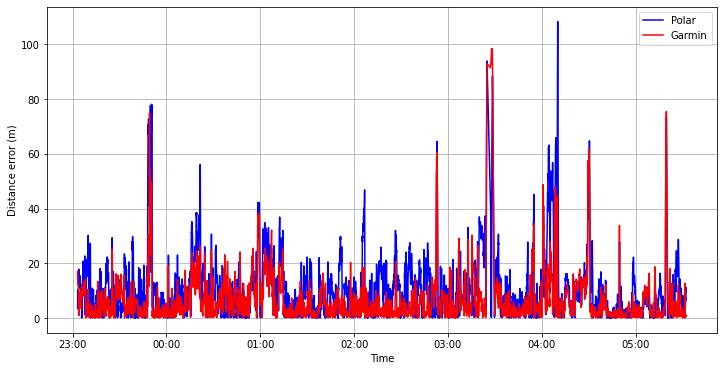

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(polar_df['time'], polar_df['distance_to_route'], color='blue', label='Polar')
plt.plot(garmin_df['time'], garmin_df['distance_to_route'], color='red', label='Garmin')
plt.xlabel('Time')
plt.ylabel('Distance error (m)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig(output_dir + '/location-error.png', bbox_inches='tight', facecolor='white')

In [24]:
polar_df = get_total_distance(polar_df)
polar_df.iloc[-1]['accumulated_distance']

50497.246318562145

In [25]:
garmin_df = get_total_distance(garmin_df)
garmin_df.iloc[-1]['accumulated_distance']

48070.81283248653

In [26]:
polar_df.iloc[-1]['accumulated_distance'] - garmin_df.iloc[-1]['accumulated_distance']

2426.4334860756135